# Notebook de Inferencia - Clasificar Imágenes Nuevas

Este notebook te permite clasificar imágenes nuevas usando el modelo ya entrenado.

**No necesitas entrenar nada**, solo cargar el modelo y predecir.

In [4]:
# Importar el predictor
from inference import ImageClassifierPredictor
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## 1. Cargar el modelo entrenado

In [5]:
# Cargar el predictor
predictor = ImageClassifierPredictor(
    model_dir='export_v4',  # Cambia esto si guardaste el modelo en otro lugar
    device='cuda'  # 'cuda', 'cpu' o 'auto'
)

print(f"\nModelo listo para clasificar imágenes de las siguientes clases:")
for i, cls in enumerate(predictor.classes, 1):
    print(f"  {i}. {cls}")

Usando dispositivo: cuda
✓ Modelo cargado exitosamente
✓ Clases: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']
✓ Listo para clasificar imágenes de tamaño 32x32

Modelo listo para clasificar imágenes de las siguientes clases:
  1. cpu
  2. mesa
  3. mouse
  4. nada
  5. pantalla
  6. silla
  7. teclado


## 2. Clasificar una imagen individual

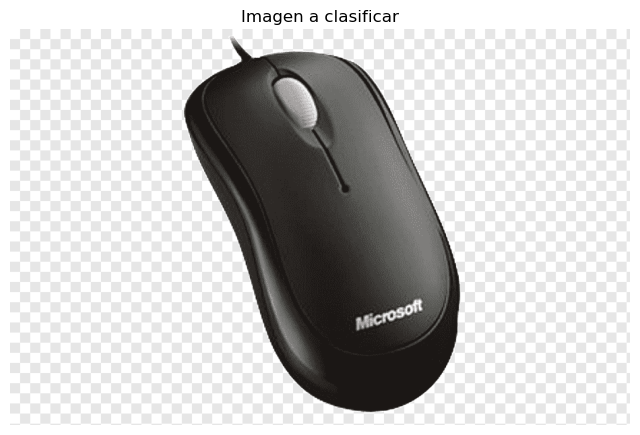


Predicciones:
----------------------------------------
1. mouse: 43.92%
2. nada: 33.91%
3. teclado: 17.83%

🎯 Predicción final: mouse (43.92%)


In [13]:
# Ruta a tu imagen
image_path = 'imagenes_externas_para_clasificar/mouse.png'  # CAMBIA ESTO

# Predecir (top-3 resultados)
predictions = predictor.predict(image_path, top_k=3)

# Mostrar imagen
img = Image.open(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Imagen a clasificar')
plt.show()

# Mostrar predicciones
print("\nPredicciones:")
print("-" * 40)
for i, pred in enumerate(predictions, 1):
    print(f"{i}. {pred['class']}: {pred['confidence_pct']:.2f}%")

print(f"\n🎯 Predicción final: {predictions[0]['class']} ({predictions[0]['confidence_pct']:.2f}%)")

## 3. Clasificar múltiples imágenes

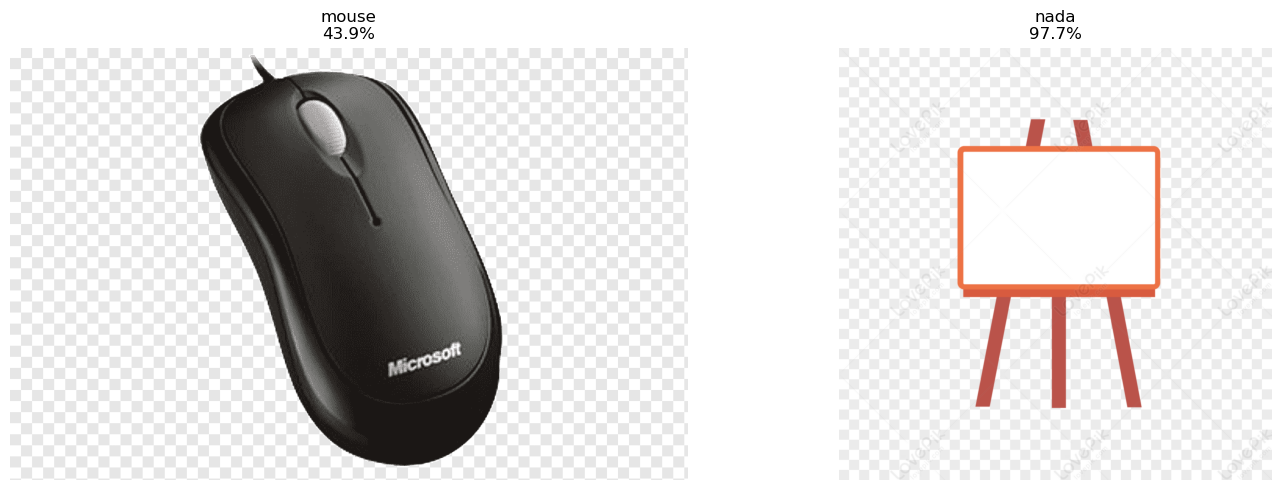

In [14]:
# Lista de imágenes
image_paths = [
    'imagenes_externas_para_clasificar/mouse.png',
    'imagenes_externas_para_clasificar/nada.png'
]

# Predecir en batch
results = predictor.predict_batch(image_paths, top_k=1)

# Visualizar resultados
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
if len(image_paths) == 1:
    axes = [axes]

for idx, (img_path, result) in enumerate(results.items()):
    if result['success']:
        img = Image.open(img_path)
        axes[idx].imshow(img)
        
        pred = result['predictions'][0]
        title = f"{pred['class']}\n{pred['confidence_pct']:.1f}%"
        axes[idx].set_title(title)
    else:
        axes[idx].set_title(f"Error\n{result['error']}")
    
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Clasificar todas las imágenes en una carpeta

In [15]:
# Carpeta con imágenes
folder_path = 'imagenes_externas_para_clasificar'  # CAMBIA ESTO

# Clasificar todas las imágenes
results = predictor.predict_folder(folder_path, top_k=1)

# Mostrar resumen
print("\nResumen de clasificación:")
print("=" * 60)

successful = 0
failed = 0
class_counts = {cls: 0 for cls in predictor.classes}

for img_path, result in results.items():
    if result['success']:
        successful += 1
        pred_class = result['predictions'][0]['class']
        class_counts[pred_class] += 1
        print(f"✓ {img_path}: {pred_class}")
    else:
        failed += 1
        print(f"✗ {img_path}: Error - {result['error']}")

print("\n" + "=" * 60)
print(f"Total imágenes: {len(results)}")
print(f"Exitosas: {successful}")
print(f"Fallidas: {failed}")

print("\nDistribución por clase:")
for cls, count in class_counts.items():
    if count > 0:
        print(f"  {cls}: {count} imágenes")

Encontradas 7 imágenes

Resumen de clasificación:
✓ imagenes_externas_para_clasificar/pantalla.png: pantalla
✓ imagenes_externas_para_clasificar/nada.png: nada
✓ imagenes_externas_para_clasificar/silla.png: mesa
✓ imagenes_externas_para_clasificar/teclado.png: cpu
✓ imagenes_externas_para_clasificar/cpu.png: pantalla
✓ imagenes_externas_para_clasificar/mouse.png: mouse
✓ imagenes_externas_para_clasificar/mesa.png: nada

Total imágenes: 7
Exitosas: 7
Fallidas: 0

Distribución por clase:
  cpu: 1 imágenes
  mesa: 1 imágenes
  mouse: 1 imágenes
  nada: 2 imágenes
  pantalla: 2 imágenes


## 5. Función auxiliar para evaluar confianza

In [17]:
def classify_with_confidence_threshold(image_path, threshold=70.0):
    """
    Clasifica una imagen solo si la confianza supera un umbral.
    Útil para detectar imágenes ambiguas o fuera de dominio.
    """
    predictions = predictor.predict(image_path, top_k=3)
    top_pred = predictions[0]
    
    print(f"\nImagen: {image_path}")
    print("-" * 40)
    
    if top_pred['confidence_pct'] >= threshold:
        print(f"✓ Clasificación: {top_pred['class']}")
        print(f"  Confianza: {top_pred['confidence_pct']:.2f}%")
        return top_pred['class']
    else:
        print(f"⚠ Confianza baja ({top_pred['confidence_pct']:.2f}%)")
        print(f"  Top-3 predicciones:")
        for i, pred in enumerate(predictions, 1):
            print(f"    {i}. {pred['class']}: {pred['confidence_pct']:.2f}%")
        print("  Recomendación: Revisar manualmente")
        return None

# Ejemplo de uso
classify_with_confidence_threshold('imagenes_externas_para_clasificar/mouse.png', threshold=75.0)


Imagen: imagenes_externas_para_clasificar/mouse.png
----------------------------------------
⚠ Confianza baja (43.92%)
  Top-3 predicciones:
    1. mouse: 43.92%
    2. nada: 33.91%
    3. teclado: 17.83%
  Recomendación: Revisar manualmente


## 6. Exportar resultados a CSV

In [18]:
import pandas as pd

def export_results_to_csv(results, output_file='predictions.csv'):
    """
    Exporta los resultados de predicción a un archivo CSV.
    """
    data = []
    
    for img_path, result in results.items():
        if result['success']:
            pred = result['predictions'][0]
            data.append({
                'imagen': img_path,
                'clase_predicha': pred['class'],
                'confianza_%': pred['confidence_pct'],
                'exito': 'Sí'
            })
        else:
            data.append({
                'imagen': img_path,
                'clase_predicha': 'N/A',
                'confianza_%': 0,
                'exito': 'No',
                'error': result['error']
            })
    
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"✓ Resultados exportados a: {output_file}")
    return df

# Ejemplo de uso:
# results = predictor.predict_folder('carpeta_imagenes/')
# df = export_results_to_csv(results, 'resultados_clasificacion.csv')
# df.head()

## 7. Información del modelo cargado

In [19]:
# Ver metadata completo del modelo
import json

print("Información del modelo:")
print("=" * 60)
print(json.dumps(predictor.metadata, indent=2, ensure_ascii=False))

Información del modelo:
{
  "framework": "pytorch",
  "created_at": "2025-11-01T11:48:22.088553",
  "classes": [
    "cpu",
    "mesa",
    "mouse",
    "nada",
    "pantalla",
    "silla",
    "teclado"
  ],
  "num_classes": 7,
  "architecture": {
    "latent_dim": 128,
    "img_size": 32,
    "dropout": 0.5
  },
  "transforms": {
    "resize": 32,
    "normalize_mean": [
      0.5,
      0.5,
      0.5
    ],
    "normalize_std": [
      0.5,
      0.5,
      0.5
    ]
  },
  "training": {
    "ae_epochs": 30,
    "classifier_epochs": 25,
    "batch_size": 64,
    "ae_lr": 0.001,
    "classifier_lr": 0.001
  },
  "performance": {
    "final_train_acc": 71.57987643424536,
    "final_val_acc": 76.03305785123968,
    "best_val_acc": 76.44628099173553
  },
  "system": {
    "device": "cuda",
    "pytorch_version": "2.9.0+cu128"
  }
}
